In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

In [2]:
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")

C:\Users\Abhijit\AppData\Local\Temp\ipykernel_15268\741535701.py:3: DtypeWarning: Columns (12,13,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/v2/matches.csv")


In [3]:
matches_df = pd.merge(matches_df, events_df[["key", "week"]], left_on="event", right_on="key").rename(columns={"key_x": "key"}).drop(columns=["key_y"])

In [4]:
team_years_df = team_years_df[team_years_df.year == 2023]
matches_df = matches_df[(matches_df.year == 2023) & (matches_df.status == "Completed") & (matches_df.offseason == False)].sort_values(by=["time"])

In [5]:
starting_epas = {x.team: x.epa_start for _, x in team_years_df.iterrows()}

print(starting_epas[5511])

25.5


In [6]:
class TeamYear:
    def __init__(self, init):
        self.count = 0
        self.total = [init]
        
    def add_match(self, count, total):
        self.count += count
        self.total.append(total)

In [7]:
class ModelStats:
    def __init__(self):
        self.win_prob = []
        
    def record_stats(self, match, red_pred, blue_pred, win_prob):
        winner = {"blue": 0, "red": 1, "draw": 0.5}[match.winner]
        common = {"week": match.week, "event": match.event, "playoff": match.playoff, "key": match.key}
        
        self.win_prob.append({
            **common, 
            "winner": match.winner, 
            "win_prob": win_prob, 
            "conf": max(win_prob, 1 - win_prob), 
            "acc": (win_prob > 0.5) == winner, 
            "mse": (winner - win_prob) ** 2,
        })
            
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean"})
            rounded = [f"{temp.conf:.4f}", f"{temp.acc:.4f}", f"{temp.mse:.4f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE")
        agg_win_prob("Season", lambda x: x[(x.week < 8)])
        agg_win_prob("Champs", lambda x: x[(x.week == 8)])
        agg_win_prob("Quals", lambda x: x[(x.playoff == False)])
        agg_win_prob("Elims", lambda x: x[(x.playoff == True)])
        agg_win_prob("Total", lambda x: x)
        print()

In [8]:
MEAN_MULT = 1.5

def sum_func(arr, mean):
    return min(sum(arr), MEAN_MULT * mean + 0.8 * (sum(arr) - MEAN_MULT * mean))

def margin_func(x):
    return min(1, max(0, 1 / 24 * (x - 12)))


def percent_func(x):
    return min(0.5, max(0.3, 0.5 - 0.2 / 6 * (x - 6)))


MEAN, SD = 74, 29


def process_season(sum_func):
    team_years = {}
    model_stats = ModelStats()
    for _, t in team_years_df.iterrows():
        team = t.team
        prior = MEAN / 3
        if team in starting_epas:
            prior = starting_epas[team]
            
        team_years[team] = TeamYear(prior)

    for _, match in matches_df.iterrows():
        red_teams = [int(match.red_1), int(match.red_2), int(match.red_3)]
        blue_teams = [int(match.blue_1), int(match.blue_2), int(match.blue_3)]

        red_pred = sum_func([team_years[t].total[-1] for t in red_teams], MEAN)
        blue_pred = sum_func([team_years[t].total[-1] for t in blue_teams], MEAN)
        win_prob = 1 / (1 + 10 ** (-5/8 * (red_pred - blue_pred) / SD))
        
        model_stats.record_stats(match, red_pred, blue_pred, win_prob)
        
        weight = 1 / 3 if match.playoff else 1

        red_score = match.red_no_fouls
        blue_score = match.blue_no_fouls
        for teams, my_score, opp_score, my_pred, opp_pred in [
            (red_teams, red_score, blue_score, red_pred, blue_pred),
            (blue_teams, blue_score, red_score, blue_pred, red_pred),
        ]:
            for team in teams:
                team_year = team_years[team]
                percent, margin_factor = percent_func(team_year.count), margin_func(team_year.count)
                error = ((my_score - my_pred) + margin_factor * (opp_pred - opp_score)) / (1 + margin_factor)
                total = team_year.total[-1] + percent * weight * error / 3
                team_year.add_match(0 if match.playoff else 1, total)
    
    model_stats.print_stats()
    return team_years

print("No Nonlinear Sum")
team_years_simple = process_season(lambda x, y: sum(x))
print()

print("Nonlinear Sum")
team_years = process_season(sum_func)

No Nonlinear Sum
Win Prob
Category	Count	Conf	Acc	MSE
Season		2339	0.6953	0.7525	0.1635
Champs		0	nan	nan	nan
Quals		1923	0.6916	0.7535	0.1633
Elims		416	0.7125	0.7476	0.1641
Total		2339	0.6953	0.7525	0.1635


Nonlinear Sum
Win Prob
Category	Count	Conf	Acc	MSE
Season		2339	0.6946	0.7525	0.1635
Champs		0	nan	nan	nan
Quals		1923	0.6916	0.7535	0.1633
Elims		416	0.7089	0.7476	0.1645
Total		2339	0.6946	0.7525	0.1635



<IPython.core.display.Javascript object>


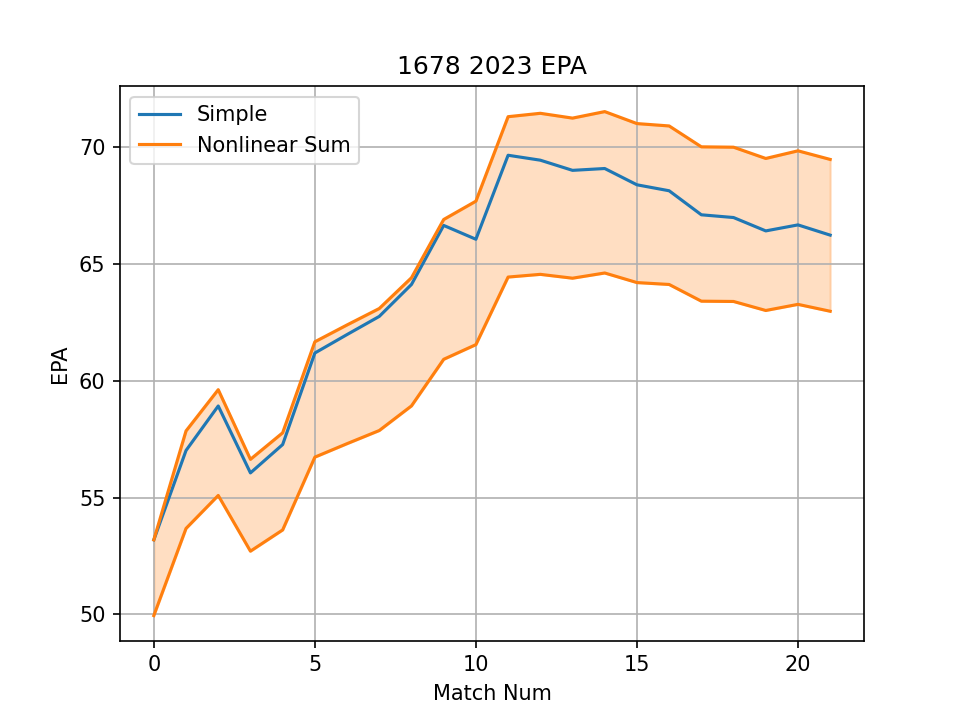

In [9]:
import numpy as np

def nonlinear_map(x, mean):
    return min(x, MEAN_MULT * mean / 3 + 0.8 * (x - MEAN_MULT * mean / 3))

fig, ax = plt.subplots()

team = 1678

team_ratings_simple = team_years_simple[team].total
team_ratings = team_years[team].total
N = len(team_ratings)

ax.plot(range(N), team_ratings_simple, label="Simple")
ax.plot(range(N), [nonlinear_map(x, MEAN) for x in team_ratings], label="Nonlinear Sum")
ax.plot(range(N), team_ratings, color="tab:orange")
ax.fill_between(range(N), [nonlinear_map(x, MEAN) for x in team_ratings], team_ratings, color="tab:orange", alpha=0.25)
# plt.axhline(y=68, xmin=19/58, xmax=56/58, color='black', linestyle="--")
# plt.axhline(y=78, xmin=19/58, xmax=56/58, color='black', linestyle="--")

ax.grid()
ax.legend()
# ax.set_ylim(40, 80)
ax.set_xlabel("Match Num")
ax.set_ylabel("EPA")
ax.set_title(str(team) + " 2023 EPA")
fig.show()